In [1]:
from datetime import datetime

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score,\
ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import StratifiedKFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df

,bid,channel,createdon,cust_name,date_of_birth,email,email_domain_score,email_score,godate,insurance_flg,ip,isFraud,nationality,netprice_thb,p_attempts,paidon,passenger_passport_score,passenger_score,payer_country,payer_name,proxy,recent_abuse,role_id,seats,tor,useragent,usr_name,vehclass_id,vpn
0,6524445,affiliate,2021-05-01 00:21:17+07:00,Tiffany Stephenson,1999-07-04,ryanbrianna@outlook.com,0.0,10.0,2021-07-01 07:30:00+07:00,0,213.89.6.2,0,SE,115.000000,0,2021-06-29 16:57:12.177348+07:00,0.0,0.0,SE,Tiffany Stephenson,NaN,NaN,user,1,NaN,"Phone,sv,SEK",Tiffany Stephenson,van,NaN
1,5800338,affiliate,2021-05-01 00:30:19+07:00,Amanda Cooper,2002-06-07,dustin85@gmail.com,0.0,10.0,2021-05-29 13:35:00+07:00,1,124.106.133.175,0,TH,985.180176,0,2021-05-25 03:58:15.692073+07:00,0.0,0.0,NU,NaN,0.0,0.0,user,1,0.0,"Phone,en,PHP",Amanda Cooper,avia,0.0
2,7897646,direct,2021-05-01 01:09:12+07:00,Victoria Cortez,NaN,johnny40@gmail.com,0.0,2.0,2021-05-10 10:40:00+07:00,1,183.88.101.237,0,TH,2400.000000,7,2021-05-05 18:40:55.424451+07:00,0.0,0.0,CH,Victoria Cortez,NaN,NaN,user,2,NaN,"Phone,de,THB",Victoria Cortez,avia,NaN
3,7644834,direct,2021-05-01 01:29:33+07:00,Victoria Cortez,1995-08-02,johnny40@gmail.com,0.0,2.0,2021-05-10 12:00:00+07:00,1,183.88.101.237,0,TH,410.000000,2,2021-05-06 04:07:31.171406+07:00,0.0,0.0,CH,Victoria Cortez,NaN,NaN,user,2,NaN,"Phone,de,THB",Victoria Cortez,bus,NaN
4,7462960,NaN,2021-05-01 01:36:36+07:00,Francisco Wagner,1989-01-16,margaretcastaneda@gmail.com,0.0,5.0,2021-05-02 10:33:00+07:00,1,183.171.184.148,0,TH,573.537903,0,2021-04-27 17:24:15.421043+07:00,0.0,0.0,NU,NaN,0.0,0.0,user,1,0.0,"Phone,en,MYR",Francisco Wagner,train,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464217,5923406,affiliate,2023-11-15 04:24:36+07:00,Darius Brown,2004-01-08,dsheppard@gmail.com,0.0,0.0,2024-01-27 15:30:00+07:00,0,113.190.209.133,0,VN,400.000000,0,2024-01-23 23:05:09.835391+07:00,0.0,0.0,FR,BRAD COOK,1.0,0.0,user,2,0.0,"Desktop,fr,EUR",Darius Brown,van,0.0
3464218,6913658,affiliate,2023-11-15 04:24:36+07:00,Darius Brown,1995-11-09,dsheppard@gmail.com,0.0,0.0,2024-01-31 09:00:00+07:00,0,113.190.209.133,0,VN,280.000000,0,2024-01-29 00:39:45.276437+07:00,0.0,0.0,FR,BRAD COOK,1.0,0.0,user,2,0.0,"Desktop,fr,EUR",Darius Brown,van,0.0
3464219,6161618,affiliate,2023-11-15 04:24:50+07:00,Terry Rodriguez,1996-11-09,smithchristopher@hotmail.com,0.0,0.0,2024-04-26 06:00:00+07:00,0,92.13.13.176,0,GB,723.564941,0,2024-04-21 11:21:40.006445+07:00,0.0,0.0,NU,NaN,1.0,0.0,user,2,0.0,"Desktop,en,GBP",Terry Rodriguez,ferry,0.0
3464220,5861839,unknown,2023-11-15 04:25:08+07:00,Michael Watkins,1983-02-28,pjacobs@tbs-education.org,0.0,0.0,2023-11-18 09:00:00+07:00,0,91.167.173.9,0,FR,693.000000,0,2023-11-13 14:13:16.574336+07:00,0.0,0.0,FR,BRENDA PACE,NaN,NaN,user,2,NaN,"Desktop,fr,EUR",Michael Watkins,bus,NaN


### We see that fraud samples are about 0.2% of whole dataset.
### It might be quite difficult to train some model with supervised learning methods because target variable is too imbalanced.
### My main idea is to try different approaches from supervised and unsupervised learning(bagging, boosting, autoencoder, isolation forest) and combine them to 1 model(for example just train final model with using output of  another models as features).

In [4]:
df['isFraud'].value_counts(dropna=False)

isFraud
0    3456397
1       7825
Name: count, dtype: int64

### Firstly we need to make some data clean and preprocessing

In [5]:
df['createdon'] = pd.to_datetime(df['createdon'])
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['godate'] = pd.to_datetime(df['godate'])
df['paidon'] = pd.to_datetime(df['paidon'], format='ISO8601')

### There are some null values in dataset. My main aim is to fill them with something or drop them. But I prefer to do it without "losing information"

In [6]:
df.isnull().sum()

bid                               0
channel                      118148
createdon                         0
cust_name                         1
date_of_birth                 35196
email                             0
email_domain_score                0
email_score                       0
godate                            0
insurance_flg                     0
ip                              232
isFraud                           0
nationality                      41
netprice_thb                      0
p_attempts                        0
paidon                            0
passenger_passport_score          0
passenger_score                   0
payer_country                    74
payer_name                  1296718
proxy                       1708481
recent_abuse                1708481
role_id                           0
seats                             0
tor                         1708481
useragent                       232
usr_name                       5045
vehclass_id                 

In [7]:
df['channel'] = df['channel'].fillna('unknown')

### It looks like we can just frop 35k samples where date_of_birth is NULL but we see that at this subsample 748 fraud samples which is about 2% >> 0.2%. It means that NULL in date_of_birth can be useful signal

In [8]:
df.loc[df['date_of_birth'].isnull(), 'isFraud'].value_counts()

isFraud
0    34448
1      748
Name: count, dtype: int64

In [9]:
df.loc[df['date_of_birth'].notnull(), 'isFraud'].value_counts()

isFraud
0    3421949
1       7077
Name: count, dtype: int64

In [10]:
pd.to_datetime(df['date_of_birth']).min(), pd.to_datetime(df['date_of_birth']).max() 

(Timestamp('1936-01-28 00:00:00'), Timestamp('2020-02-06 00:00:00'))

In [11]:
df['date_of_birth'] = df['date_of_birth'].fillna(pd.Timestamp('1900-01-01'))

### In case when ip or nationality or payer_country is NULL looks that we will not lose information if we just drop this samples due there are not so many cases

In [12]:
df.loc[df['ip'].isnull(), 'isFraud'].value_counts()

isFraud
0    232
Name: count, dtype: int64

In [13]:
df.loc[df['nationality'].isnull(), 'isFraud'].value_counts()

isFraud
0    41
Name: count, dtype: int64

In [14]:
df.loc[df['payer_country'].isnull(), 'isFraud'].value_counts()

isFraud
0    74
Name: count, dtype: int64

In [15]:
df.loc[df['cust_name'].isnull(), 'isFraud'].value_counts()

isFraud
0    1
Name: count, dtype: int64

In [16]:
df = df.loc[(df['ip'].notnull())&\
            (df['nationality'].notnull())&\
            (df['payer_country'].notnull())&\
            (df['cust_name'].notnull())
           ].reset_index(drop=True)

### Just fill names with "uknown" string. I have an intuition that it can be used in feature engineering

In [17]:
df['payer_name'] = df['payer_name'].fillna('unknown_payer_name')
df['usr_name'] = df['usr_name'].fillna('unknown_usr_name')

### Since proxy and recent_abuse and tor are binary flags they will be used as categorical features
### Casting them to int type will not lead to problems because clever models can "understand" that it's categorical(for example split in decision tree solves this problem)

In [18]:
df['proxy'] = df['proxy'].fillna(-1).astype(int)
df['recent_abuse'] = df['recent_abuse'].fillna(-1).astype(int)
df['tor'] = df['tor'].fillna(-1).astype(int)
df['vpn'] = df['vpn'].fillna(-1).astype(int)

In [19]:
df.isnull().sum()

bid                         0
channel                     0
createdon                   0
cust_name                   0
date_of_birth               0
email                       0
email_domain_score          0
email_score                 0
godate                      0
insurance_flg               0
ip                          0
isFraud                     0
nationality                 0
netprice_thb                0
p_attempts                  0
paidon                      0
passenger_passport_score    0
passenger_score             0
payer_country               0
payer_name                  0
proxy                       0
recent_abuse                0
role_id                     0
seats                       0
tor                         0
useragent                   0
usr_name                    0
vehclass_id                 0
vpn                         0
dtype: int64

In [20]:
df

,bid,channel,createdon,cust_name,date_of_birth,email,email_domain_score,email_score,godate,insurance_flg,ip,isFraud,nationality,netprice_thb,p_attempts,paidon,passenger_passport_score,passenger_score,payer_country,payer_name,proxy,recent_abuse,role_id,seats,tor,useragent,usr_name,vehclass_id,vpn
0,6524445,affiliate,2021-05-01 00:21:17+07:00,Tiffany Stephenson,1999-07-04,ryanbrianna@outlook.com,0.0,10.0,2021-07-01 07:30:00+07:00,0,213.89.6.2,0,SE,115.000000,0,2021-06-29 16:57:12.177348+07:00,0.0,0.0,SE,Tiffany Stephenson,-1,-1,user,1,-1,"Phone,sv,SEK",Tiffany Stephenson,van,-1
1,5800338,affiliate,2021-05-01 00:30:19+07:00,Amanda Cooper,2002-06-07,dustin85@gmail.com,0.0,10.0,2021-05-29 13:35:00+07:00,1,124.106.133.175,0,TH,985.180176,0,2021-05-25 03:58:15.692073+07:00,0.0,0.0,NU,unknown_payer_name,0,0,user,1,0,"Phone,en,PHP",Amanda Cooper,avia,0
2,7897646,direct,2021-05-01 01:09:12+07:00,Victoria Cortez,1900-01-01,johnny40@gmail.com,0.0,2.0,2021-05-10 10:40:00+07:00,1,183.88.101.237,0,TH,2400.000000,7,2021-05-05 18:40:55.424451+07:00,0.0,0.0,CH,Victoria Cortez,-1,-1,user,2,-1,"Phone,de,THB",Victoria Cortez,avia,-1
3,7644834,direct,2021-05-01 01:29:33+07:00,Victoria Cortez,1995-08-02,johnny40@gmail.com,0.0,2.0,2021-05-10 12:00:00+07:00,1,183.88.101.237,0,TH,410.000000,2,2021-05-06 04:07:31.171406+07:00,0.0,0.0,CH,Victoria Cortez,-1,-1,user,2,-1,"Phone,de,THB",Victoria Cortez,bus,-1
4,7462960,unknown,2021-05-01 01:36:36+07:00,Francisco Wagner,1989-01-16,margaretcastaneda@gmail.com,0.0,5.0,2021-05-02 10:33:00+07:00,1,183.171.184.148,0,TH,573.537903,0,2021-04-27 17:24:15.421043+07:00,0.0,0.0,NU,unknown_payer_name,0,0,user,1,0,"Phone,en,MYR",Francisco Wagner,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3463898,5923406,affiliate,2023-11-15 04:24:36+07:00,Darius Brown,2004-01-08,dsheppard@gmail.com,0.0,0.0,2024-01-27 15:30:00+07:00,0,113.190.209.133,0,VN,400.000000,0,2024-01-23 23:05:09.835391+07:00,0.0,0.0,FR,BRAD COOK,1,0,user,2,0,"Desktop,fr,EUR",Darius Brown,van,0
3463899,6913658,affiliate,2023-11-15 04:24:36+07:00,Darius Brown,1995-11-09,dsheppard@gmail.com,0.0,0.0,2024-01-31 09:00:00+07:00,0,113.190.209.133,0,VN,280.000000,0,2024-01-29 00:39:45.276437+07:00,0.0,0.0,FR,BRAD COOK,1,0,user,2,0,"Desktop,fr,EUR",Darius Brown,van,0
3463900,6161618,affiliate,2023-11-15 04:24:50+07:00,Terry Rodriguez,1996-11-09,smithchristopher@hotmail.com,0.0,0.0,2024-04-26 06:00:00+07:00,0,92.13.13.176,0,GB,723.564941,0,2024-04-21 11:21:40.006445+07:00,0.0,0.0,NU,unknown_payer_name,1,0,user,2,0,"Desktop,en,GBP",Terry Rodriguez,ferry,0
3463901,5861839,unknown,2023-11-15 04:25:08+07:00,Michael Watkins,1983-02-28,pjacobs@tbs-education.org,0.0,0.0,2023-11-18 09:00:00+07:00,0,91.167.173.9,0,FR,693.000000,0,2023-11-13 14:13:16.574336+07:00,0.0,0.0,FR,BRENDA PACE,-1,-1,user,2,-1,"Desktop,fr,EUR",Michael Watkins,bus,-1


### At this task I should be careful while removing anomaly points because the task is specific 
### But otherwise anomalies in train set may lead to problems while training model

In [21]:
df['netprice_thb'].mean(), df['netprice_thb'].std()

(741.666151552458, 24744.35934651751)

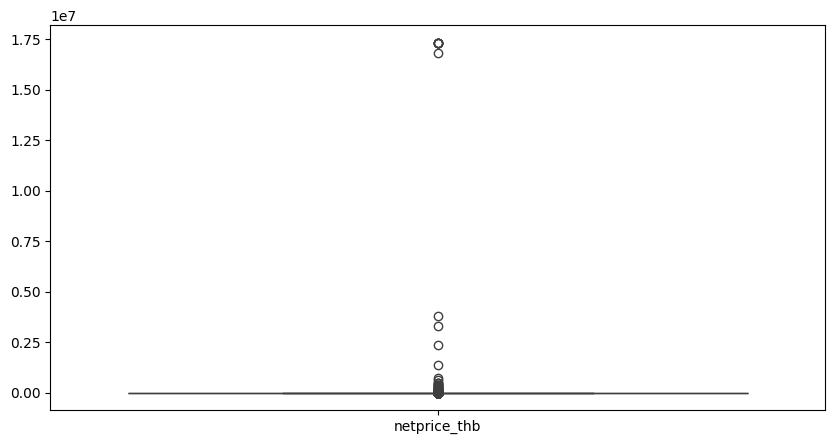

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.loc[df['isFraud'] == 0, ['netprice_thb']])
plt.show()

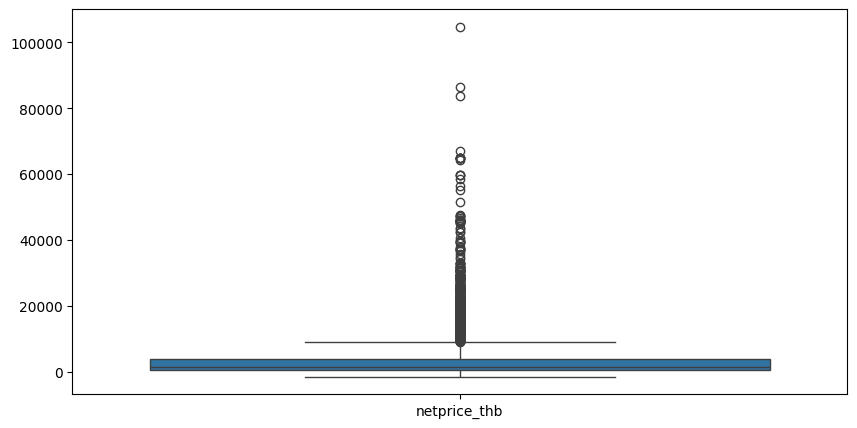

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.loc[df['isFraud'] == 1, ['netprice_thb']])
plt.show()

### Obviously values like 5e6 in train are mistakes. But for fair evaluation we can't remove such samples with high netprice_thb(for example 10000). Otherwise it will be a signal for a model to label such samples as fraud which is not absolutely true

In [24]:
df.loc[(df['isFraud'] == 1) & (df['netprice_thb'] > 5e4)].shape

(17, 29)

In [25]:
df.loc[df['netprice_thb'] > 5e4].shape

(76, 29)

### I guess it's ok if we just drop all samples with netprice_thb > 50000

In [26]:
df = df.loc[df['netprice_thb'] <= 5e4].reset_index(drop=True)

### We got much better variance that was before

In [27]:
df['netprice_thb'].mean(), df['netprice_thb'].std()

(700.9546599537199, 960.1965591309468)

# Important thoughts
### In our final model we want high f-score. But to be more exact we prefer recall that close to 1(meaning that we catch almost all frauds) and acceptable precision(for example 0.8, meaning that in some cases we block transaction and send it to department to solve the problem manually. Since there are not so much frauds it will be ok)
### Dropping some samples as we did above means that in production there would be some if-conditions with 100% recall and bad precision. But that's ok because this subsample of cases is too small and will not affect final metric

### We also see that there are some cases when netprice_thb is negative which looks like mistakes in data

In [28]:
df.loc[(df['isFraud'] == 1) & (df['netprice_thb'] < 0)].shape

(1, 29)

In [29]:
df.loc[(df['isFraud'] == 0) & (df['netprice_thb'] < 0)].shape

(80, 29)

In [30]:
df = df.loc[df['netprice_thb'] >= 0].reset_index(drop=True)

In [31]:
df.max()

bid                                                    9880728
channel                                                unknown
createdon                            2023-11-30 23:59:52+07:00
cust_name                                           zoe horton
date_of_birth                              2020-02-06 00:00:00
email                                           zzuniga@me.com
email_domain_score                                        30.0
email_score                                               10.0
godate                               2035-12-16 18:30:00+07:00
insurance_flg                                                1
ip                                                 99.99.63.19
isFraud                                                      1
nationality                                                 ZZ
netprice_thb                                           50000.0
p_attempts                                                 144
paidon                        2035-12-14 10:39:10.65331

### There are also strange values in p_attempts feature

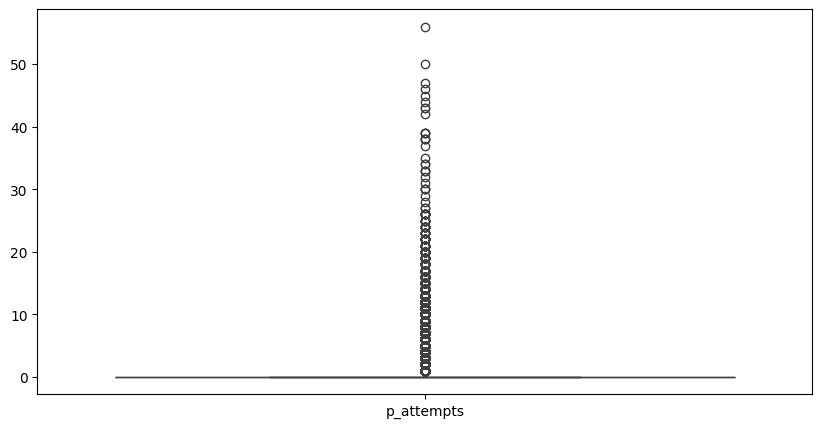

In [32]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.loc[df['isFraud'] == 0, ['p_attempts']])
plt.show()

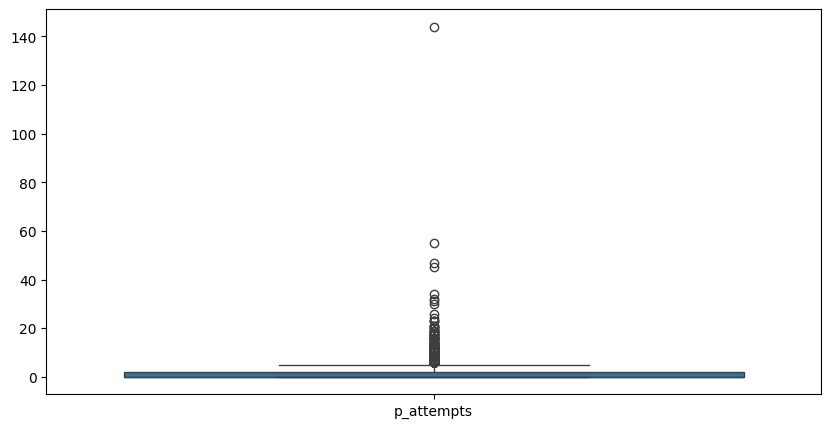

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.loc[df['isFraud'] == 1, ['p_attempts']])
plt.show()

In [34]:
df['p_attempts'].mean(), df['p_attempts'].std()

(0.11170305212911108, 0.573222639460517)

In [35]:
df.loc[(df['isFraud'] == 0) & (df['p_attempts'] > 20)].shape

(87, 29)

In [36]:
df.loc[(df['isFraud'] == 1) & (df['p_attempts'] > 20)].shape

(16, 29)

### Just drop this cases

In [37]:
df = df.loc[df['p_attempts'] <= 20].reset_index(drop=True)

In [38]:
df['p_attempts'].mean(), df['p_attempts'].std()

(0.11082753043544037, 0.5448759459320898)

### Seats feature

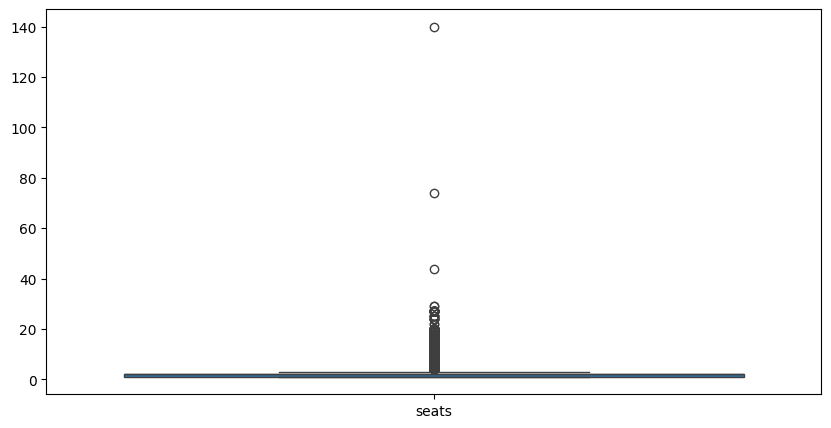

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.loc[df['isFraud'] == 0, ['seats']])
plt.show()

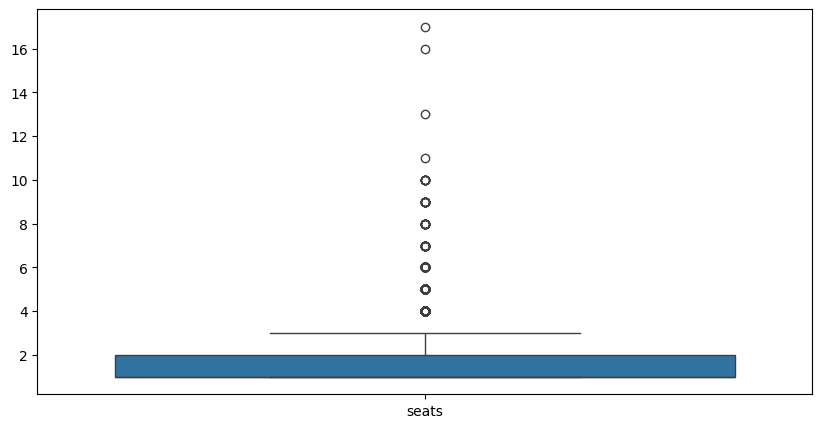

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.loc[df['isFraud'] == 1, ['seats']])
plt.show()

In [41]:
df['seats'].mean(), df['seats'].std()

(1.835898792109926, 1.0425414118024317)

In [42]:
df.loc[(df['isFraud'] == 1), 'seats'].max()

17

In [43]:
df.loc[df['seats'] > 17].shape

(264, 29)

In [44]:
df = df.loc[df['seats'] <= 17].reset_index(drop=True)

In [45]:
df['seats'].mean(), df['seats'].std()

(1.8344036272091504, 1.0255804277504945)

### It's also strange that godate = 2035-12-16 and paidon = 2035-12-14. Let's filter such cases

In [46]:
df.max()

bid                                                    9880728
channel                                                unknown
createdon                            2023-11-30 23:59:52+07:00
cust_name                                           zoe horton
date_of_birth                              2020-02-06 00:00:00
email                                           zzuniga@me.com
email_domain_score                                        30.0
email_score                                               10.0
godate                               2035-12-16 18:30:00+07:00
insurance_flg                                                1
ip                                                 99.99.63.19
isFraud                                                      1
nationality                                                 ZZ
netprice_thb                                           50000.0
p_attempts                                                  20
paidon                        2035-12-14 10:39:10.65331

In [47]:
df['godate'].min(), df['godate'].max()

(Timestamp('2019-12-24 14:30:00+0700', tz='UTC+07:00'),
 Timestamp('2035-12-16 18:30:00+0700', tz='UTC+07:00'))

In [48]:
df.loc[df['godate'] >= pd.Timestamp(ts_input='2025-01-01', tz='UTC+07:00')].shape

(46, 29)

In [49]:
df.loc[df['godate'] >= pd.Timestamp(ts_input='2025-01-01', tz='UTC+07:00'), 'isFraud'].value_counts()

isFraud
0    46
Name: count, dtype: int64

In [50]:
df = df.loc[df['godate'] < pd.Timestamp(ts_input='2025-01-01', tz='UTC+07:00')].reset_index(drop=True)

In [51]:
df

,bid,channel,createdon,cust_name,date_of_birth,email,email_domain_score,email_score,godate,insurance_flg,ip,isFraud,nationality,netprice_thb,p_attempts,paidon,passenger_passport_score,passenger_score,payer_country,payer_name,proxy,recent_abuse,role_id,seats,tor,useragent,usr_name,vehclass_id,vpn
0,6524445,affiliate,2021-05-01 00:21:17+07:00,Tiffany Stephenson,1999-07-04,ryanbrianna@outlook.com,0.0,10.0,2021-07-01 07:30:00+07:00,0,213.89.6.2,0,SE,115.000000,0,2021-06-29 16:57:12.177348+07:00,0.0,0.0,SE,Tiffany Stephenson,-1,-1,user,1,-1,"Phone,sv,SEK",Tiffany Stephenson,van,-1
1,5800338,affiliate,2021-05-01 00:30:19+07:00,Amanda Cooper,2002-06-07,dustin85@gmail.com,0.0,10.0,2021-05-29 13:35:00+07:00,1,124.106.133.175,0,TH,985.180176,0,2021-05-25 03:58:15.692073+07:00,0.0,0.0,NU,unknown_payer_name,0,0,user,1,0,"Phone,en,PHP",Amanda Cooper,avia,0
2,7897646,direct,2021-05-01 01:09:12+07:00,Victoria Cortez,1900-01-01,johnny40@gmail.com,0.0,2.0,2021-05-10 10:40:00+07:00,1,183.88.101.237,0,TH,2400.000000,7,2021-05-05 18:40:55.424451+07:00,0.0,0.0,CH,Victoria Cortez,-1,-1,user,2,-1,"Phone,de,THB",Victoria Cortez,avia,-1
3,7644834,direct,2021-05-01 01:29:33+07:00,Victoria Cortez,1995-08-02,johnny40@gmail.com,0.0,2.0,2021-05-10 12:00:00+07:00,1,183.88.101.237,0,TH,410.000000,2,2021-05-06 04:07:31.171406+07:00,0.0,0.0,CH,Victoria Cortez,-1,-1,user,2,-1,"Phone,de,THB",Victoria Cortez,bus,-1
4,7462960,unknown,2021-05-01 01:36:36+07:00,Francisco Wagner,1989-01-16,margaretcastaneda@gmail.com,0.0,5.0,2021-05-02 10:33:00+07:00,1,183.171.184.148,0,TH,573.537903,0,2021-04-27 17:24:15.421043+07:00,0.0,0.0,NU,unknown_payer_name,0,0,user,1,0,"Phone,en,MYR",Francisco Wagner,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3463328,5923406,affiliate,2023-11-15 04:24:36+07:00,Darius Brown,2004-01-08,dsheppard@gmail.com,0.0,0.0,2024-01-27 15:30:00+07:00,0,113.190.209.133,0,VN,400.000000,0,2024-01-23 23:05:09.835391+07:00,0.0,0.0,FR,BRAD COOK,1,0,user,2,0,"Desktop,fr,EUR",Darius Brown,van,0
3463329,6913658,affiliate,2023-11-15 04:24:36+07:00,Darius Brown,1995-11-09,dsheppard@gmail.com,0.0,0.0,2024-01-31 09:00:00+07:00,0,113.190.209.133,0,VN,280.000000,0,2024-01-29 00:39:45.276437+07:00,0.0,0.0,FR,BRAD COOK,1,0,user,2,0,"Desktop,fr,EUR",Darius Brown,van,0
3463330,6161618,affiliate,2023-11-15 04:24:50+07:00,Terry Rodriguez,1996-11-09,smithchristopher@hotmail.com,0.0,0.0,2024-04-26 06:00:00+07:00,0,92.13.13.176,0,GB,723.564941,0,2024-04-21 11:21:40.006445+07:00,0.0,0.0,NU,unknown_payer_name,1,0,user,2,0,"Desktop,en,GBP",Terry Rodriguez,ferry,0
3463331,5861839,unknown,2023-11-15 04:25:08+07:00,Michael Watkins,1983-02-28,pjacobs@tbs-education.org,0.0,0.0,2023-11-18 09:00:00+07:00,0,91.167.173.9,0,FR,693.000000,0,2023-11-13 14:13:16.574336+07:00,0.0,0.0,FR,BRENDA PACE,-1,-1,user,2,-1,"Desktop,fr,EUR",Michael Watkins,bus,-1


In [52]:
df['paidon'].min(), df['paidon'].max()

(Timestamp('2019-12-21 16:01:12.781995+0700', tz='UTC+07:00'),
 Timestamp('2024-12-15 07:21:22.510659+0700', tz='UTC+07:00'))

In [53]:
df['createdon'].min(), df['createdon'].max()

(Timestamp('2021-05-01 00:21:17+0700', tz='UTC+07:00'),
 Timestamp('2023-11-30 23:59:52+0700', tz='UTC+07:00'))

In [54]:
df['date_of_birth'].min(), df['date_of_birth'].max()

(Timestamp('1900-01-01 00:00:00'), Timestamp('2020-02-06 00:00:00'))

### It's also strange that there are transaction where date_of_birth is 2020-02-06. Let's filter it by setting min age 18 years

In [55]:
df['date_of_birth'].sort_values(ascending=False).head(30)

1062985   2020-02-06
1915257   2019-04-23
1520511   2019-03-09
3235597   2018-10-20
1458507   2018-04-17
220716    2018-04-16
2723555   2018-04-12
2430682   2018-03-18
3185125   2018-01-14
2353042   2017-11-28
3451293   2017-08-07
2675172   2017-07-27
30665     2017-06-03
1455440   2017-05-13
3276693   2017-05-08
615427    2017-04-06
3071034   2017-04-01
442909    2017-03-09
2013579   2017-03-07
649930    2017-01-05
2175816   2016-12-24
796573    2016-12-22
1821492   2016-11-04
1468480   2016-08-24
287223    2016-08-19
710635    2016-08-05
709405    2016-07-28
102198    2016-07-25
2587004   2016-07-14
2392083   2016-06-20
Name: date_of_birth, dtype: datetime64[ns]

In [56]:
df.loc[df['date_of_birth'] > pd.Timestamp('2006-01-01'), 'isFraud'].value_counts()

isFraud
0    75266
1      169
Name: count, dtype: int64

### Upd: looks like bad idea

### Next step is to make features "understandable" for model a.k.a feature engineering

### I'm removing bid feature because in my opinion it's absolutely doesn't affect target variable
### It's also written in task description that bid is unique but it's not
### I had an idea that the slice of duplicated bids would be useful as feature 'has_clone_bid' but it seems like not

In [57]:
cur = df.groupby(['bid']).count().reset_index()
duplicated_bids = set(cur.loc[cur['channel'] > 1, 'bid'])

In [58]:
# 0.2% like in the whole dataset
df.loc[df['bid'].isin(duplicated_bids), 'isFraud'].value_counts()

isFraud
0    1913872
1       4294
Name: count, dtype: int64

In [59]:
df['isFraud'].value_counts()

isFraud
0    3455542
1       7791
Name: count, dtype: int64

In [60]:
df = df.drop(columns=['bid'])

### Now let's move to categorical features that I want to encode
### It can be seen that categorical features have type 'object' and have few unique values
### For example: channel
### Obviously it would be quite stupid to encode such features like email

In [61]:
df.dtypes

channel                                        object
createdon                   datetime64[ns, UTC+07:00]
cust_name                                      object
date_of_birth                          datetime64[ns]
email                                          object
email_domain_score                            float64
email_score                                   float64
godate                      datetime64[ns, UTC+07:00]
insurance_flg                                   int64
ip                                             object
isFraud                                         int64
nationality                                    object
netprice_thb                                  float64
p_attempts                                      int64
paidon                      datetime64[ns, UTC+07:00]
passenger_passport_score                      float64
passenger_score                               float64
payer_country                                  object
payer_name                  

In [62]:
df.nunique()

channel                           8
createdon                   3194069
cust_name                    402089
date_of_birth                 17740
email                        707346
email_domain_score                2
email_score                       4
godate                       273020
insurance_flg                     2
ip                          1220970
isFraud                           2
nationality                     225
netprice_thb                 471848
p_attempts                       21
paidon                      3463333
passenger_passport_score          2
passenger_score                   2
payer_country                   197
payer_name                   403939
proxy                             3
recent_abuse                      3
role_id                          15
seats                            17
tor                               3
useragent                      1844
usr_name                     356101
vehclass_id                      10
vpn                         

### Categorical features are: channel, payer_country, role_id, vehclass_id, nationality

In [63]:
def encode_categorical_feature(dataframe, feature):
    le = LabelEncoder()
    dataframe[feature] = le.fit_transform(dataframe[feature])
    return dataframe

In [64]:
df = encode_categorical_feature(df, 'channel')
df = encode_categorical_feature(df, 'payer_country')
df = encode_categorical_feature(df, 'role_id')
df = encode_categorical_feature(df, 'vehclass_id')
df = encode_categorical_feature(df, 'nationality')

### Also parse and encode useragent field

In [65]:
df['useragent_device'] = df['useragent'].apply(lambda x: x.split(',')[0])
df['useragent_country'] = df['useragent'].apply(lambda x: x.split(',')[1])
df['useragent_currency'] = df['useragent'].apply(lambda x: x.split(',')[2])

df = encode_categorical_feature(df, 'useragent_device')
df = encode_categorical_feature(df, 'useragent_country')
df = encode_categorical_feature(df, 'useragent_currency')

df = df.drop(columns=['useragent'])

### About using names. I have an idea: checking if cust_name==payer_name==usr_name.
### Another ideas:
### - Check average p_attempts made by user. If it's high it might be a signal for a fraud(checking stolen credit cards)
### - Check number of bookings made by user
### - Frequency of bookings made by user(in days)
### - Average price of bookings made by user
### - Std price of bookings made by user
### - Unique payer_name's used by user(different credit cards)
### - Unique countries by user
### - Unique ips by user
### - Unique devices by user
### - Unique emails

In [66]:
df['cust_name'] = df['cust_name'].apply(lambda x: x.strip().lower())
df['payer_name'] = df['payer_name'].apply(lambda x: x.strip().lower())
df['usr_name'] = df['usr_name'].apply(lambda x: x.strip().lower())

df['cust_name_equals_payer_name'] = (df['cust_name'] == df['payer_name']).astype(int)
df['usr_name_equals_payer_name'] = (df['usr_name'] == df['payer_name']).astype(int)
df['cust_name_equals_usr_name'] = (df['cust_name'] == df['usr_name']).astype(int)

### Before implementing features with aggregations mentioned above we need firstly split dataset to train and test. It's preventing possible data leak
### I'm going to take the last month(by createdon) as the test set

In [67]:
df['createdon'].min(), df['createdon'].max()

(Timestamp('2021-05-01 00:21:17+0700', tz='UTC+07:00'),
 Timestamp('2023-11-30 23:59:52+0700', tz='UTC+07:00'))

In [68]:
train = df.loc[df['createdon'] < pd.Timestamp(ts_input='2023-11-01', tz='UTC+07:00')].reset_index(drop=True)
test = df.loc[df['createdon'] >= pd.Timestamp(ts_input='2023-11-01', tz='UTC+07:00')].reset_index(drop=True)

### Comment: it's nice that our split is stratified

In [69]:
test['isFraud'].value_counts()

isFraud
0    372975
1       881
Name: count, dtype: int64

In [70]:
def add_agregation_statistic(train, test, agg_col, value_col, statistic, null_value=None):
    if statistic == 'mean':
        temp = train[[agg_col, value_col]].groupby([agg_col]).mean().reset_index()
    if statistic == 'std':
        temp = train[[agg_col, value_col]].groupby([agg_col]).std().reset_index()
    if statistic == 'nunique':
        temp = train[[agg_col, value_col]].groupby([agg_col]).nunique().reset_index()
    if statistic == 'count':
        temp = train[[agg_col, value_col]].groupby([agg_col]).count().reset_index()
        new_col_name = 'by_' + agg_col + '_' + statistic
        temp = temp.rename(columns={value_col: new_col_name})
        
    if statistic != 'count':
        new_col_name = 'by_' + agg_col + '_' + value_col + '_' + statistic
        temp = temp.rename(columns={value_col: new_col_name})
    if null_value is not None:
        temp = temp.loc[temp[agg_col] != null_value]
        
    train = train.merge(right=temp, how='left', on=[agg_col])
    train[new_col_name] = train[new_col_name].fillna(-1)
    test = test.merge(right=temp, how='left', on=[agg_col])
    test[new_col_name] = test[new_col_name].fillna(-1)
    
    return (train, test)

In [71]:
train, test = add_agregation_statistic(train, test, 'usr_name', 'p_attempts', 'mean', 'unknown_usr_name')
train, test = add_agregation_statistic(train, test, 'usr_name', 'channel', 'count', 'unknown_usr_name')
train, test = add_agregation_statistic(train, test, 'usr_name', 'netprice_thb', 'mean', 'unknown_usr_name')
train, test = add_agregation_statistic(train, test, 'usr_name', 'netprice_thb', 'std', 'unknown_usr_name')
train, test = add_agregation_statistic(train, test, 'usr_name', 'payer_name', 'nunique', 'unknown_usr_name')
train, test = add_agregation_statistic(train, test, 'usr_name', 'payer_country', 'nunique', 'unknown_usr_name')
train, test = add_agregation_statistic(train, test, 'usr_name', 'ip', 'nunique', 'unknown_usr_name')
train, test = add_agregation_statistic(train, test, 'usr_name', 'email', 'nunique', 'unknown_usr_name')
train, test = add_agregation_statistic(train, test, 'usr_name', 'useragent_device', 'nunique', 'unknown_usr_name')

# Frequency
temp = train[['usr_name', 'createdon']].groupby(['usr_name']).agg(['min', 'max', 'count'])
temp = temp.reset_index()
temp['timedelta'] = (temp['createdon']['max'] - temp['createdon']['min']).apply(lambda x: x.days)
temp['by_usr_name_freq'] = temp['timedelta'] / temp['createdon']['count']
temp = temp[['usr_name', 'by_usr_name_freq']]
temp = temp.loc[temp['usr_name'] != 'unknown_usr_name'].reset_index(drop=True)
temp = pd.DataFrame(data={
    'usr_name': temp['usr_name'], 
    'by_usr_name_freq': temp['by_usr_name_freq']
})
train = train.merge(right=temp, how='left', on=['usr_name'])
train['by_usr_name_freq'] = train['by_usr_name_freq'].fillna(-1)
test = test.merge(right=temp, how='left', on=['usr_name'])
test['by_usr_name_freq'] = test['by_usr_name_freq'].fillna(-1)

### In the same way I build agregation features by ip:
### - Count bookings(if high it's strange)
### - Unique users
### - Avg p_attempts
### - Frequency of bookings
### - Price avg and std
### - Unique payer_name's
### - Unique countries
### - Unique devices
### - Unique emails

In [72]:
train, test = add_agregation_statistic(train, test, 'ip', 'channel', 'count')
train, test = add_agregation_statistic(train, test, 'ip', 'usr_name', 'nunique')
train, test = add_agregation_statistic(train, test, 'ip', 'email', 'nunique')
train, test = add_agregation_statistic(train, test, 'ip', 'p_attempts', 'mean')
train, test = add_agregation_statistic(train, test, 'ip', 'netprice_thb', 'mean')
train, test = add_agregation_statistic(train, test, 'ip', 'netprice_thb', 'std')
train, test = add_agregation_statistic(train, test, 'ip', 'payer_name', 'nunique')
train, test = add_agregation_statistic(train, test, 'ip', 'payer_country', 'nunique')
train, test = add_agregation_statistic(train, test, 'ip', 'useragent_device', 'nunique')

# Frequency
temp = train[['ip', 'createdon']].groupby(['ip']).agg(['min', 'max', 'count'])
temp = temp.reset_index()
temp['timedelta'] = (temp['createdon']['max'] - temp['createdon']['min']).apply(lambda x: x.days)
temp['by_ip_freq'] = temp['timedelta'] / temp['createdon']['count']
temp = temp[['ip', 'by_ip_freq']]
temp = pd.DataFrame(data={
    'ip': temp['ip'], 
    'by_ip_freq': temp['by_ip_freq']
})
train = train.merge(right=temp, how='left', on=['ip'])
train['by_ip_freq'] = train['by_ip_freq'].fillna(-1)
test = test.merge(right=temp, how='left', on=['ip'])
test['by_ip_freq'] = test['by_ip_freq'].fillna(-1)

### Analogically with email

In [73]:
train, test = add_agregation_statistic(train, test, 'email', 'channel', 'count')
train, test = add_agregation_statistic(train, test, 'email', 'usr_name', 'nunique')
train, test = add_agregation_statistic(train, test, 'email', 'ip', 'nunique')
train, test = add_agregation_statistic(train, test, 'email', 'p_attempts', 'mean')
train, test = add_agregation_statistic(train, test, 'email', 'netprice_thb', 'mean')
train, test = add_agregation_statistic(train, test, 'email', 'netprice_thb', 'std')
train, test = add_agregation_statistic(train, test, 'email', 'payer_name', 'nunique')
train, test = add_agregation_statistic(train, test, 'email', 'payer_country', 'nunique')
train, test = add_agregation_statistic(train, test, 'email', 'useragent_device', 'nunique')

# Frequency
temp = train[['email', 'createdon']].groupby(['email']).agg(['min', 'max', 'count'])
temp = temp.reset_index()
temp['timedelta'] = (temp['createdon']['max'] - temp['createdon']['min']).apply(lambda x: x.days)
temp['by_email_freq'] = temp['timedelta'] / temp['createdon']['count']
temp = temp[['email', 'by_email_freq']]
temp = pd.DataFrame(data={
    'email': temp['email'], 
    'by_email_freq': temp['by_email_freq']
})
train = train.merge(right=temp, how='left', on=['email'])
train['by_email_freq'] = train['by_email_freq'].fillna(-1)
test = test.merge(right=temp, how='left', on=['email'])
test['by_email_freq'] = test['by_email_freq'].fillna(-1)

### At this stage I finish with names, email and ip. I have one more idea: to check if email domain is unreliable. But we already have feature email_domain_score which is enough I guess

In [74]:
train = train.drop(columns=['cust_name', 'email', 'ip', 'payer_name', 'usr_name'])
test = test.drop(columns=['cust_name', 'email', 'ip', 'payer_name', 'usr_name'])

### Let's move to datetime(or just date) features
### We should remember that we gonna use tree models and neural models
### In my opinion date_of_birth can be just encoded to (year, month, day)
### About createdon, paidon, godate: We also can encode them to (y, m, d, h, m, s). But I also want to add features: 
### - paidon-createdon (might be a signal gor fraud if payment is fast) 
### - godate-paidon (might be a signal gor fraud if payment is just before travel)
### - godate-createdon

In [75]:
def encode_date(df):
    df['date_of_birth_year'] = df['date_of_birth'].dt.year
    df['date_of_birth_month'] = df['date_of_birth'].dt.month
    df['date_of_birth_day'] = df['date_of_birth'].dt.day
    df = df.drop(columns=['date_of_birth'])
    return df

In [76]:
def encode_datetime(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_hour'] = df[col].dt.hour
    df[col + '_minute'] = df[col].dt.minute
    df[col + '_second'] = df[col].dt.second
    return df

In [77]:
def encode_all_datetime_features(df):
    df = encode_date(df)
    df = encode_datetime(df, 'createdon')
    df = encode_datetime(df, 'paidon')
    df = encode_datetime(df, 'godate')
    df['paidon_minus_createdon'] = (df['paidon'] - df['createdon']).apply(lambda x: x.total_seconds())
    df['godate_minus_createdon'] = (df['godate'] - df['createdon']).apply(lambda x: x.total_seconds())
    df['godate_minus_paidon'] = (df['godate'] - df['paidon']).apply(lambda x: x.total_seconds())
    return df

In [78]:
train = encode_all_datetime_features(train)
test = encode_all_datetime_features(test)

In [79]:
train = train.drop(columns=['createdon', 'godate', 'paidon'])
test = test.drop(columns=['createdon', 'godate', 'paidon'])

In [80]:
train.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('int32')], dtype=object)

In [81]:
train.shape

(3089477, 78)

### At this stage I finished with feature engineering

### Now we move to experiments with models
### I also want to make some feature selection. We have 77 features in train. It's not so much but noisy features can lead to problems in training
### Let's see if we have some highly correlated features. 

In [82]:
corr_matrix = train.corr()

In [83]:
np.fill_diagonal(corr_matrix.values, 0)

In [84]:
max_corrs = corr_matrix.max()
max_corrs[max_corrs > 0.99]

by_usr_name_count                 0.998925
by_usr_name_payer_name_nunique    0.990009
by_usr_name_email_nunique         0.990009
by_ip_count                       0.994838
by_ip_usr_name_nunique            0.999997
by_ip_email_nunique               0.999997
by_ip_payer_name_nunique          0.999941
by_email_count                    0.998925
paidon_minus_createdon            0.999339
godate_minus_createdon            0.999339
dtype: float64

In [85]:
corr_matrix.loc[list(max_corrs[max_corrs > 0.99].index), max_corrs[max_corrs > 0.99].index]

,by_usr_name_count,by_usr_name_payer_name_nunique,by_usr_name_email_nunique,by_ip_count,by_ip_usr_name_nunique,by_ip_email_nunique,by_ip_payer_name_nunique,by_email_count,paidon_minus_createdon,godate_minus_createdon
by_usr_name_count,0.000000,0.127480,0.151212,0.849561,0.843599,0.843813,0.842796,0.998925,-0.049913,-0.049912
by_usr_name_payer_name_nunique,0.127480,0.000000,0.990009,0.083342,0.082832,0.082852,0.082763,0.119586,-0.004313,-0.004285
by_usr_name_email_nunique,0.151212,0.990009,0.000000,0.103871,0.103131,0.103159,0.103033,0.143282,-0.006192,-0.006163
by_ip_count,0.849561,0.083342,0.103871,0.000000,0.994618,0.994838,0.993803,0.850618,-0.043048,-0.043040
by_ip_usr_name_nunique,0.843599,0.082832,0.103131,0.994618,0.000000,0.999997,0.999941,0.844646,-0.047669,-0.047660
by_ip_email_nunique,0.843813,0.082852,0.103159,0.994838,0.999997,0.000000,0.999929,0.844861,-0.047521,-0.047512
by_ip_payer_name_nunique,0.842796,0.082763,0.103033,0.993803,0.999941,0.999929,0.000000,0.843842,-0.047704,-0.047695
by_email_count,0.998925,0.119586,0.143282,0.850618,0.844646,0.844861,0.843842,0.000000,-0.049959,-0.049958
paidon_minus_createdon,-0.049913,-0.004313,-0.006192,-0.043048,-0.047669,-0.047521,-0.047704,-0.049959,0.000000,0.999339
godate_minus_createdon,-0.049912,-0.004285,-0.006163,-0.043040,-0.047660,-0.047512,-0.047695,-0.049958,0.999339,0.000000


In [86]:
drop_cols = ['by_usr_name_email_nunique', 'by_usr_name_email_nunique', 
             'by_email_count', 'by_ip_usr_name_nunique', 'by_ip_payer_name_nunique', 
             'godate_minus_createdon', 'by_ip_email_nunique']
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [87]:
train.shape, test.shape

((3089477, 72), (373856, 72))

### Let's try some simple random forest

In [88]:
X_train = train.drop(columns=['isFraud'])
y_train = train['isFraud']
X_test = test.drop(columns=['isFraud'])
y_test = test['isFraud']

In [89]:
def calculate_metrics(y_true, pred):
    precision = precision_score(y_true, pred)
    recall = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1-score: {:.2f}'.format(f1))
    return (precision, recall, f1)

In [90]:
%%time
model = RandomForestClassifier(max_depth=10, n_jobs=-1, n_estimators=500, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

CPU times: user 54min 56s, sys: 26.7 s, total: 55min 23s
Wall time: 7min 55s


In [91]:
calculate_metrics(y_test, pred)

Precision: 1.00
Recall: 0.48
F1-score: 0.64


(1.0, 0.47559591373439275, 0.6446153846153846)

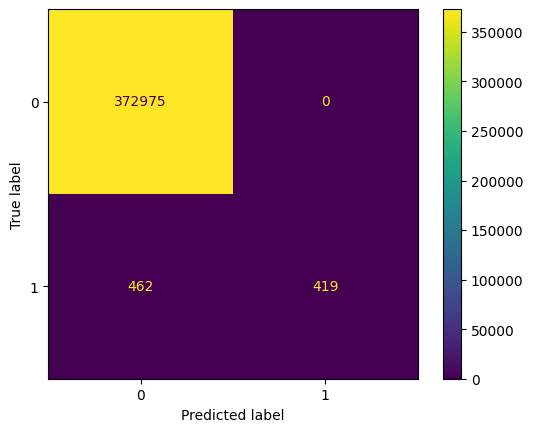

In [92]:
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

### It looks like our model is "careful". It can be solved by correct threshold

In [93]:
pred_proba = model.predict_proba(X_test)[:, 1]

### Here we see that there is a point with precision=0.8 and recall=0.942 which is more preferable for us

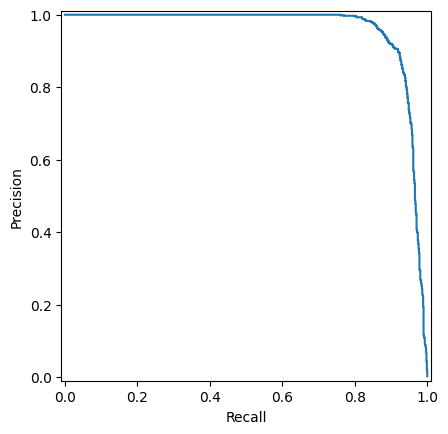

In [94]:
precision, recall, _ = precision_recall_curve(y_test, pred_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [95]:
temp = pd.DataFrame(data={
    'precision': precision,
    'recall': recall
})

In [96]:
temp.loc[(temp['precision'] > 0.799) & (temp['precision'] < 0.8001)]

,precision,recall
357089,0.799038,0.943246
357090,0.799808,0.943246
357091,0.799615,0.942111


### This observations lead to some thoughts:
### As I mentioned before we need to have recall close to 1. I assume that 0.95 recall would be quite good meaning that we catch 95% of frauds. In real life it's very important to discuss this question with business
### That's why I decide to choose our metric to optimize as precision@recall=0.95

### I also want to make some feature selection at this stage before starting hard experiments with models. Why? Just to decrease training time somehow and avoid noisy useless features
### There are many ways to make feature selection(we did some using correlation matrix before). But I'm convinced that if I try RFE or Permutation Importance I will spend too much time on this task
### So I'm making feature selection according to baseline model's feature importances and SHAP

In [97]:
temp = pd.DataFrame(data={
    'feature': model.feature_names_in_,
    'importance': model.feature_importances_
})

In [98]:
temp.sort_values(by=['importance'], ascending=False).reset_index(drop=True)

,feature,importance
0,date_of_birth_year,0.275318
1,godate_minus_paidon,0.207235
2,date_of_birth_month,0.105122
3,by_ip_netprice_thb_mean,0.037610
4,netprice_thb,0.028158
5,date_of_birth_day,0.027902
6,vehclass_id,0.026764
7,p_attempts,0.022672
8,by_email_netprice_thb_mean,0.021024
9,by_ip_p_attempts_mean,0.019433


### Since calculating SHAP values takes too much time. We only calculate them on a fraud-slice

In [113]:
X_test_true = test.loc[test['isFraud'] == 1].drop(columns=['isFraud']).reset_index(drop=True)

In [121]:
explainer = shap.Explainer(model.predict, X_test_true)

In [122]:
shap_values = explainer(X_test_true)

PermutationExplainer explainer: 882it [04:44,  3.02it/s]                        


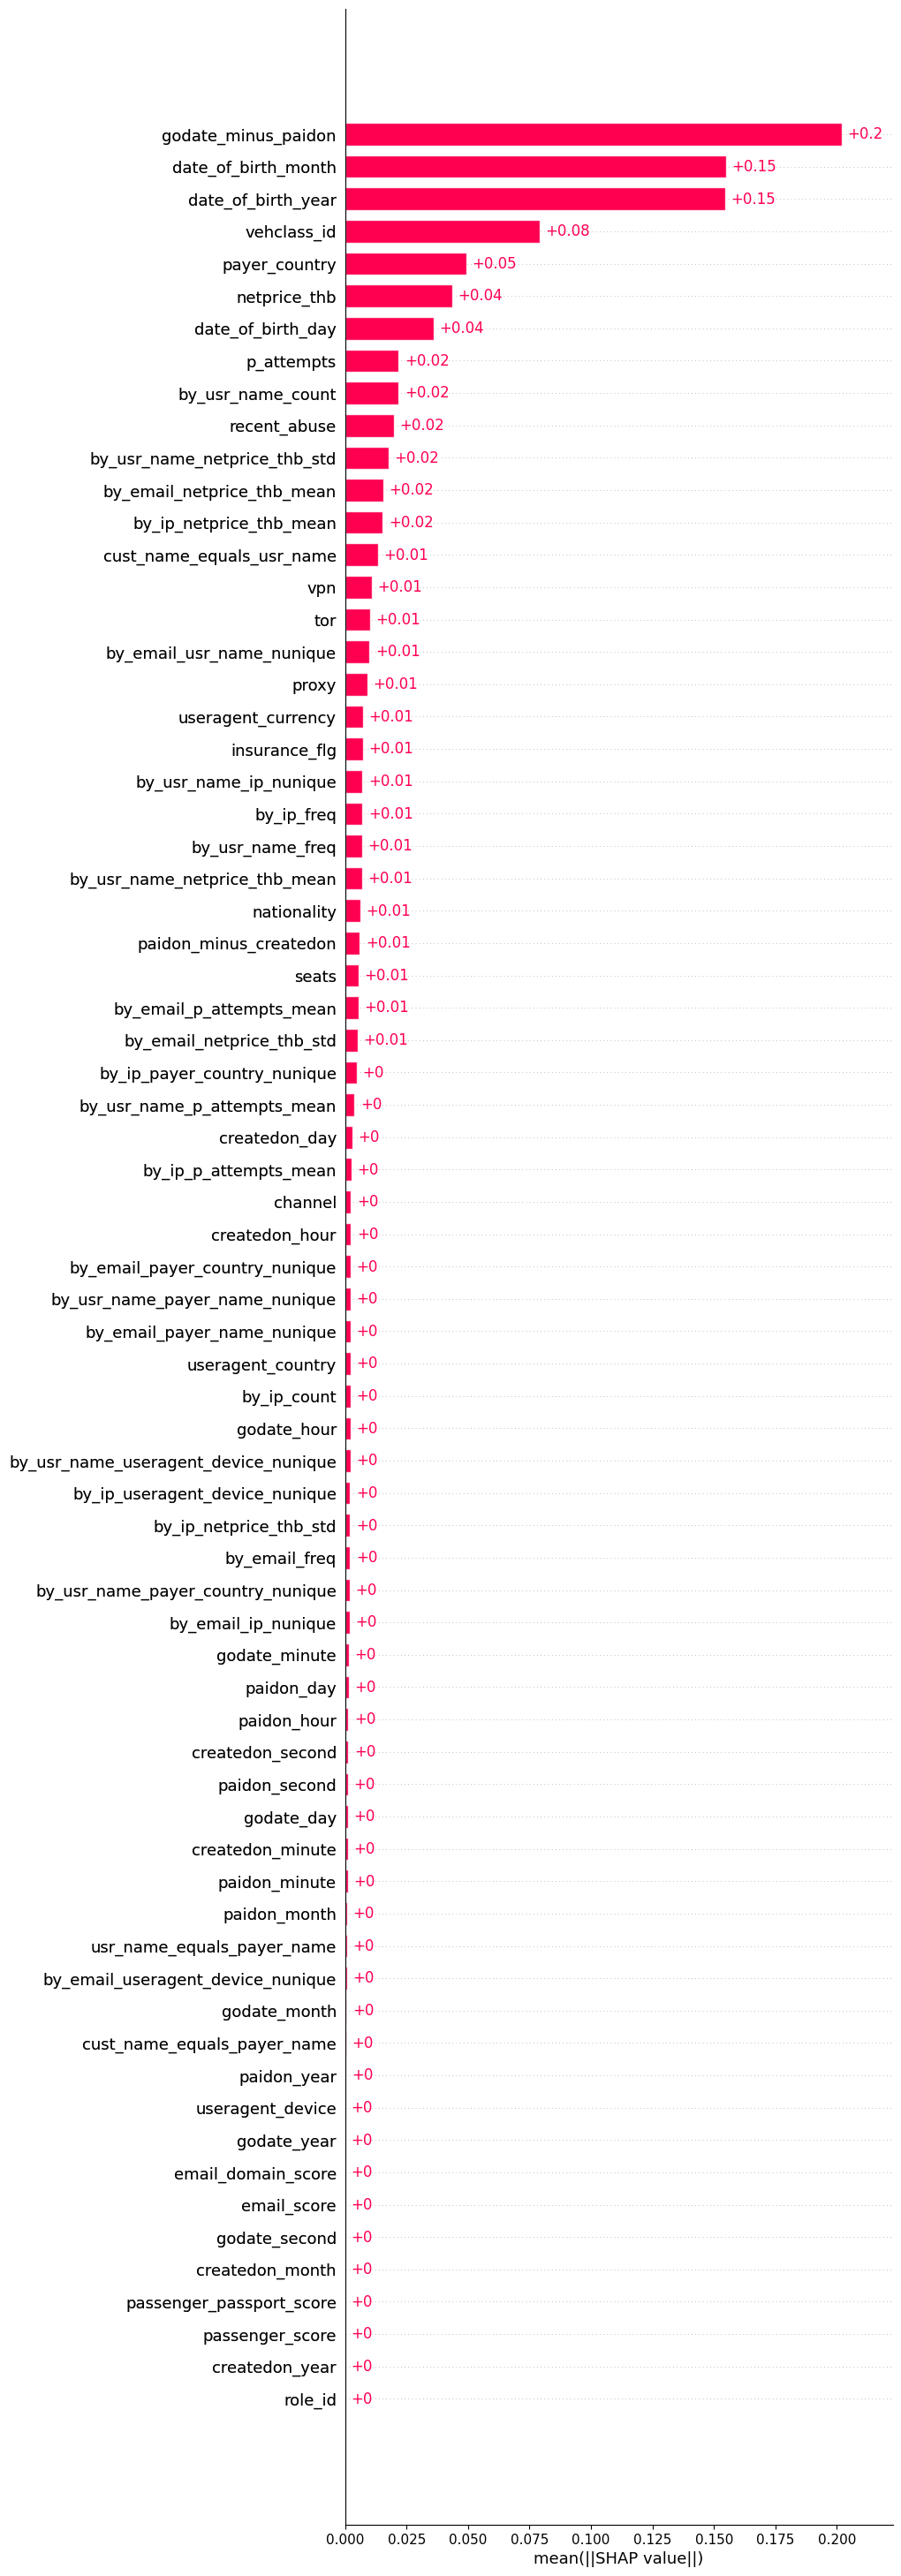

In [131]:
shap.plots.bar(shap_values.abs, max_display=71)

### I decided to drop features that make too low contribution according to shap values

In [133]:
drop_cols = [
    'role_id', 'createdon_year', 'passenger_score', 'passenger_passport_score',
    'createdon_month', 'godate_second', 'email_score', 'email_domain_score',
    'godate_year', 'useragent_device', 'paidon_year', 'cust_name_equals_payer_name',
    'godate_month'
]

In [134]:
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [135]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

### Now let's implement several methods. I will use 5-fold cross-validation for tuning params of models. Target metric is precision@recall=0.95

In [136]:
X_train = train.drop(columns=['isFraud'])
y_train = train['isFraud']
X_test = test.drop(columns=['isFraud'])
y_test = test['isFraud']

In [138]:
class RFModel:
    def __init__(self, params={}):
        self.params = params
        if 'max_depth' in self.params:
            self.params['max_depth'] = int(self.params['max_depth'])
        if 'n_estimators' in self.params:
            self.params['n_estimators'] = int(self.params['n_estimators'])
        self.params['n_jobs'] = -1
        self.model = None        

    def fit(self, X, y, random_state=42):
        self.model = RandomForestClassifier(**self.params)
        self.model.fit(X=X, y=y)

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]
    
    def calculate_metric(self, y_true, pred):
        precision, recall, threshold = precision_recall_curve(y_true, pred)
        temp = pd.DataFrame(data={
            'precision': precision,
            'recall': recall
        })
        if temp.loc[temp['recall'] >= 0.95, 'precision'].shape[0] == 0:
            return 0
        return float(temp.loc[temp['recall'] >= 0.95, 'precision'].max())

In [139]:
def score(X_train, y_train, X_test, y_test, params):
#     train
    model = RFModel(params)
    model.fit(X_train, y_train)
#     predict
    pred = model.predict(X_test)
    return model.calculate_metric(y_test, pred)

In [140]:
def objective(params, X=X_train, y=y_train):
    skf = StratifiedKFold(n_splits=5)
    scores = []
    print(params)
    for i, (fit_index, val_index) in enumerate(skf.split(X, y)):
        X_fit = X.loc[fit_index]
        y_fit = y.loc[fit_index]
        X_val = X.loc[val_index]
        y_val = y.loc[val_index]
        print(datetime.now())
        scores.append(score(X_fit, y_fit, X_val, y_val, params))
        print(datetime.now())
    return {'loss': -np.mean(scores), 'params': params, 'status': STATUS_OK}

In [107]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 300, 1000, 100),
    'criterion': hp.choice(label='criterion', options=['gini', 'entropy', 'log_loss'])
}

### At this stage I implemented hyperparameter tuning. But I run it in my laptop so I don't have a lost of cpus. 1 iteration takes about 3 minutes. That's why I run some "fake hyperparam-tuning" meaning only 4 iterations(instead of 50-100).
### I know that I possibly could rent some virtual machines in GCP or AWS but it costs money and also take some time to configure it.

In [108]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=objective,
          # пространство поиска гиперпараметров  
            space=space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=4,
          # куда сохранять историю поиска
            trials=trials,
          # progressbar
            show_progressbar=True
        )

{'criterion': 'log_loss', 'max_depth': 4.0, 'n_estimators': 600.0}              
2025-02-11 18:09:59.012368                                                      
2025-02-11 18:13:38.807999                                                      
2025-02-11 18:13:39.565139                                                      
2025-02-11 18:17:20.073889                                                      
2025-02-11 18:17:20.651592                                                      
2025-02-11 18:21:00.634936                                                      
2025-02-11 18:21:01.215683                                                      
2025-02-11 18:24:38.546226                                                      
2025-02-11 18:24:39.153373                                                      
2025-02-11 18:28:19.965050                                                      
{'criterion': 'entropy', 'max_depth': 7.0, 'n_estimators': 300.0}               
2025-02-11 18:28:20.805457  

### Let's results on a test set

In [111]:
best

{'criterion': 1, 'max_depth': 8.0, 'n_estimators': 900.0}

In [112]:
best['criterion'] = 'entropy'
best

{'criterion': 'entropy', 'max_depth': 8.0, 'n_estimators': 900.0}

In [113]:
%%time
rf_model = RFModel(best)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)

CPU times: user 1h 16min 26s, sys: 38.9 s, total: 1h 17min 4s
Wall time: 10min 48s


### Unfortunately it's not better that we made previously by just taking our own parameters.
### That's why in next experiments I will not tune params. Because it takes too much time

In [114]:
rf_model.calculate_metric(y_test, pred)

0.7616014558689718

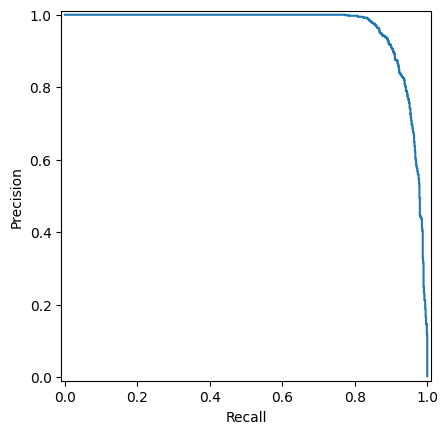

In [115]:
precision, recall, _ = precision_recall_curve(y_test, pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

### Let's return to old model

In [142]:
%%time
params = {
    'max_depth': 10,
    'n_jobs': -1,
    'n_estimators': 500,
    'random_state': 42
}
rf_model = RFModel(params)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)

CPU times: user 55min 30s, sys: 22.9 s, total: 55min 53s
Wall time: 7min 44s


### As we see dropping features above led to decrease in model perfomance. That's why I feature selection must be done carefuly. It wouldn't be possible if we used RFE

In [143]:
rf_model.calculate_metric(y_test, pred)

0.754054054054054

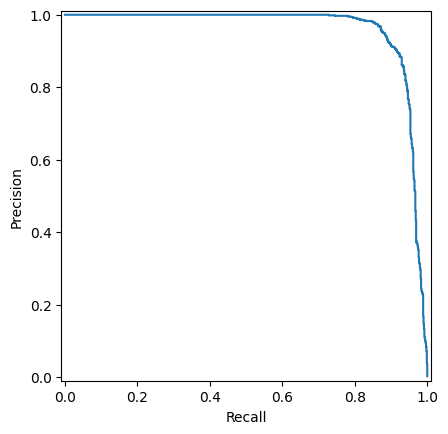

In [144]:
precision, recall, _ = precision_recall_curve(y_test, pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

### Let's try boostings. I will use LightGBM. From my experience I know that it works quite fast. Moreover there is a way to work with categorical features in LGBM

In [146]:
CATEGORICAL_FEATURES = ['channel', 'insurance_flg', 'nationality',
'payer_country', 'proxy', 'recent_abuse',
'tor', 'vehclass_id', 'vpn', 'useragent_country',
'useragent_currency', 'usr_name_equals_payer_name', 'cust_name_equals_usr_name']

In [147]:
class LGBModel:
    def __init__(self, params={}):
        self.params = params
        self.params['n_jobs'] = -1
        self.model = None        

    def fit(self, X, y):
        self.model = LGBMClassifier(**self.params)
        self.model.fit(X=X, y=y, categorical_feature=CATEGORICAL_FEATURES)

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]
    
    def calculate_metric(self, y_true, pred):
        precision, recall, threshold = precision_recall_curve(y_true, pred)
        temp = pd.DataFrame(data={
            'precision': precision,
            'recall': recall
        })
        if temp.loc[temp['recall'] >= 0.95, 'precision'].shape[0] == 0:
            return 0
        return float(temp.loc[temp['recall'] >= 0.95, 'precision'].max())

In [148]:
params = {
    'objective': 'binary',
    'colsample_bytree': 0.9,
    'learning_rate': 0.001,
    'max_depth': 15,
    'n_estimators': 4000,
    'reg_alpha': 0.005,
    'subsample': 0.9,
    'random_state': 42
}

In [149]:
%%time
lgb_model = LGBModel(params=params)
lgb_model.fit(X_train, y_train)
pred = lgb_model.predict(X_test)

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 6910, number of negative: 3082567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6304
[LightGBM] [Info] Number of data points in the train set: 3089477, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002237 -> initscore=-6.100548
[LightGBM] [Info] Start training from score -6.100548
CPU times: user 13min 50s, sys: 36.5 s, total: 14min 26s
Wall time: 3min 6s


### Got something better than Random Forest. Nice

In [150]:
lgb_model.calculate_metric(y_test, pred)

0.846309403437816

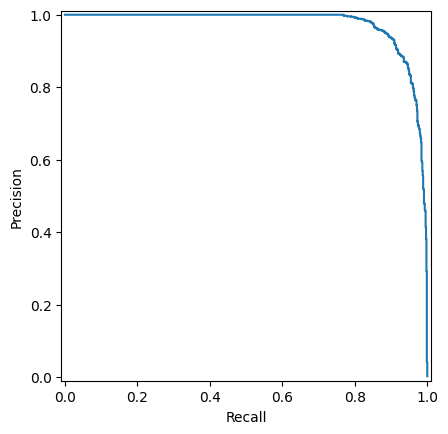

In [151]:
precision, recall, _ = precision_recall_curve(y_test, pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

### Let's try Isolation Forest for anomaly detection

In [152]:
class IFModel:
    def __init__(self, params={}):
        self.params = params
        self.params['n_jobs'] = -1
        self.model = None        

    def fit(self, X):
        self.model = IsolationForest(**self.params)
        self.model.fit(X=X)

    def predict(self, X):
        return self.model.predict(X)
    
    def calculate_metric(self, y_true, pred):
        pred_adjusted = [1 if x == -1 else 0 for x in pred]
        return (precision_score(y_true, pred_adjusted), recall_score(y_true, pred_adjusted))

In [153]:
def calculate_metric(y_true, pred):
    pred_adjusted = [1 if x == -1 else 0 for x in pred]
    return (precision_score(y_true, pred_adjusted), recall_score(y_true, pred_adjusted))

In [154]:
params = {
    'random_state': 42,
    'n_estimators': 1000,
    'contamination': 0.002,
}

In [155]:
%%time
if_model = IFModel(params=params)
if_model.fit(X_train)
pred = if_model.predict(X_test)

CPU times: user 1min 58s, sys: 7.32 s, total: 2min 5s
Wall time: 1min 55s


### Looks like isolation forests are rather bad idea. Maybe I chose wrong params

In [156]:
calculate_metric(y_test, pred)

(0.0013131976362442547, 0.0022701475595913734)

### As I mentioned before I wanted to test RF, GBM, IF and Auto-Encoders. And then I wanted to test stacking technique. Honestly I don't have so much time to do that.
### I guess it would be better if I use shap for explanation outputs of LGB model.

### Quality of LGB model

In [157]:
pred = lgb_model.predict(X_test)
lgb_model.calculate_metric(y_test, pred)

0.846309403437816

In [159]:
precision, recall, threshold = precision_recall_curve(y_test, pred)
temp = pd.DataFrame(data={
    'precision': precision,
    'recall': recall
})
temp.loc[temp['recall'] >= 0.95].sort_values(by=['precision'], ascending=False)

,precision,recall
98510,0.846309,0.950057
98509,0.845455,0.950057
98508,0.844601,0.950057
98507,0.843750,0.950057
98506,0.842900,0.950057
...,...,...
4,0.003026,1.000000
3,0.003024,1.000000
2,0.003024,1.000000
1,0.003015,1.000000


### F1-score:

In [162]:
2 * (0.846309 * 0.950057) / (0.846309 + 0.950057)

0.8951870494242266

### Let's interpret the result model and make conclusion

In [163]:
X_test_true = test.loc[test['isFraud'] == 1].drop(columns=['isFraud']).reset_index(drop=True)
explainer = shap.Explainer(lgb_model.model.predict, X_test_true)
shap_values = explainer(X_test_true)

PermutationExplainer explainer: 882it [19:51,  1.36s/it]                        


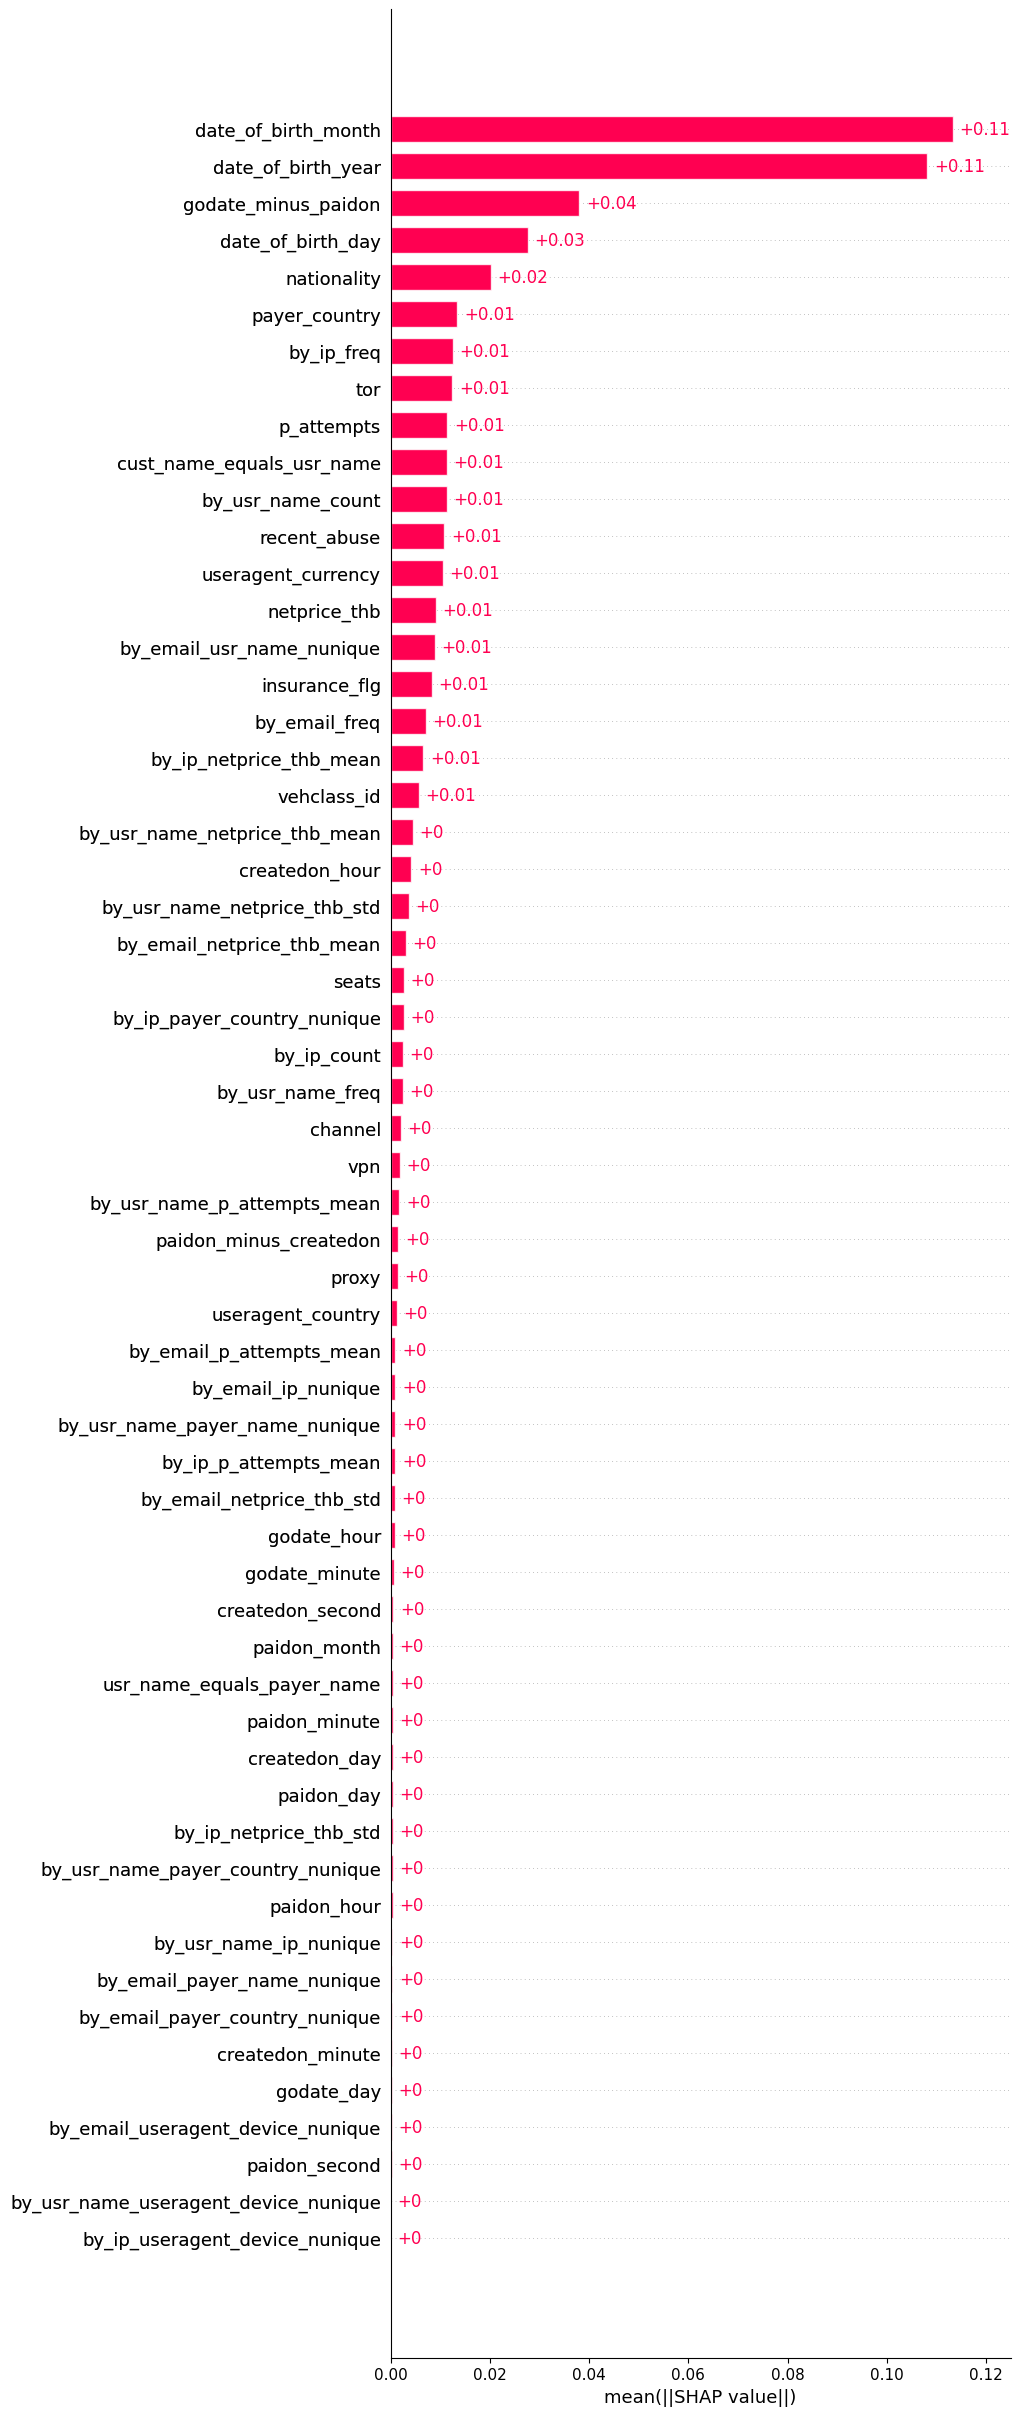

In [164]:
shap.plots.bar(shap_values.abs, max_display=71)

## Conclusion
### We trained a LightGBM model which showed result precion=0.846, recall=0.95. Which means we catch 95% of frauds and in 1 of 5 cases we just make wrong fraud detection(FP)
### As we see from feature importance bar chart:
### - date_of_birth is a good signal. To be more exact we filled null values with 1900-01-01 so missing date_of_birth is a relevant signal for fraud
### - godate_minus_paidon's relevance means that some fraud are made exactly before travel starts
### - nationality and payer_country means that some countries make more frauds
### I'm happy to see that many of generated features are in top in feature importance chart

## What improvements can be made?
### - More advanced feature selection: RFE, top-importance
### - More feature engineering: there are some features that I didn't worked with
### - Hyperparameter tuning: more iteraions with more CPUs
### - Use another models with another logic(I mean not tree-models): Neural Perceptron, AutoEncoder, KNN, Naive Bayes
### - Use ensemble of GBM, RF and models mentioned above: voting, soft-voting, stacking
### - Balance samples: oversampling, undersampling, SMOTE
### - Look at samples where model gives wrong answer and try to explain with SHAP, LIME
### - Try clusterization for anomaly detection